# New York City Airbnb

This Notebook uses the New York Airbnb open data set [available from Kaggle.com](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). At the time of writing in June 2020 there is not an open competition on this data set. I will be using this as an exercise to practice EDA and vizualization, though I will also develop a machine learning model to try and predict rental prices, using RMSE as the assesment metric.

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth',None)
import numpy as np
np.random.seed(27)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline
import seaborn as sns
sns.color_palette('muted')
sns_colours = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import kstest,boxcox,skew
from collections import defaultdict

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb


from mlxtend.plotting import heatmap, plot_learning_curves
from mlxtend.regressor import StackingRegressor

import ppscore as pps

In [2]:
# Import data. We know there is a date column so we will set it to be converted to datetime format
data = pd.read_csv('AB_NYC_2019.csv', parse_dates = ['last_review'])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48895 non-null  int64         
 1   name                            48879 non-null  object        
 2   host_id                         48895 non-null  int64         
 3   host_name                       48874 non-null  object        
 4   neighbourhood_group             48895 non-null  object        
 5   neighbourhood                   48895 non-null  object        
 6   latitude                        48895 non-null  float64       
 7   longitude                       48895 non-null  float64       
 8   room_type                       48895 non-null  object        
 9   price                           48895 non-null  int64         
 10  minimum_nights                  48895 non-null  int64         
 11  nu

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,48895.0,1.901714e+07,1.098311e+07,2539.00000,9.471945e+06,1.967728e+07,2.915218e+07,3.648724e+07
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


In [5]:
# Explicitly show the number of NaNs in each column, if any
def nan_count(df):
    for col in df:
        nans = df[col].isna().sum()
        if nans>0:
            print(f'{col} contains {nans} NaNs')

nan_count(data)

name contains 16 NaNs
host_name contains 21 NaNs
last_review contains 10052 NaNs
reviews_per_month contains 10052 NaNs


In [6]:
# Inspect missing name and host name entries for concurrence
missing_names = set(data[data['name'].isna()]['id'])
missing_hosts = set(data[data['host_name'].isna()]['id'])
missing_names.intersection(missing_hosts)

set()

In [7]:
# Inspect missing review entries for concurrence
missing_last_rev = set(data[data['last_review'].isna()]['id'])
missing_rpm = set(data[data['reviews_per_month'].isna()]['id'])
len(missing_last_rev.intersection(missing_rpm))

10052

There is no commonality between the entries with missing names and missing host names. To be able to retain these entries I will replace the name missing entries with "Information Missing".

To deal with the missing host_name information I am actually going to drop the feature from the data set. Partly this kind of feature brings privacy concerns but the main reason is that while studies have shown that the name gender and racial of the host could have an affect on price that is not something I want to investigate as part of this analysis. 

The overlap between the missing reviews per month data and missing last review date data is 100% which liekly means that these facilities have not received any reviews. I will therefore replace the NaNs in the reviews per month field with 0.

I will leave the NaNs in the date column at present. I am unliekly to use the lastreview field directly but may use it to create additional features and I will deal with any NaNs at that point.

I will also drop the id column as it is not needed. The default pandas index can serve the same purpose and has the advantage of being sequential.

In [8]:
# Fill missing values and drop ID column
data['name'].fillna('Information Missing',inplace=True)
data['host_name'].fillna('None',inplace=True)
data['reviews_per_month'].fillna(0,inplace=True)
cleaned_data = data.drop(['id','host_name'],axis=1)

In [9]:
# Reinspect dataframe information
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   name                            48895 non-null  object        
 1   host_id                         48895 non-null  int64         
 2   neighbourhood_group             48895 non-null  object        
 3   neighbourhood                   48895 non-null  object        
 4   latitude                        48895 non-null  float64       
 5   longitude                       48895 non-null  float64       
 6   room_type                       48895 non-null  object        
 7   price                           48895 non-null  int64         
 8   minimum_nights                  48895 non-null  int64         
 9   number_of_reviews               48895 non-null  int64         
 10  last_review                     38843 non-null  datetime64[ns]
 11  re

#### Splitting Data

After completing basic data cleaning I will now split off a portion of the data to be held back to use for testing the price prediction models I intend to develope. With nearly 50,000 observations I will only hold back 10% for the test set as this still gives a good test size.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_data.drop(['price'],axis=1),cleaned_data['price'],\
                                                    test_size=0.1, random_state = 27)

# Recombine training data
train_df = pd.concat([X_train,y_train],axis=1)
print(f'Training data dimensions: {train_df.shape}')
display(train_df.sample())

Training data dimensions: (44005, 14)


,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
32039,Glamping Van,10407935,Manhattan,Nolita,40.72238,-73.99466,Entire home/apt,1,15,2019-05-27,1.12,8,34,89


## EDA and Vizualizations

EDA is broken down into sections primarily looking at specific features, or groups of features, though in each section other information from the data set may be used during the analysis.

### Price

As I am treating room price as the target variable I will inspect it first.

The skewness of the room price is 18.78


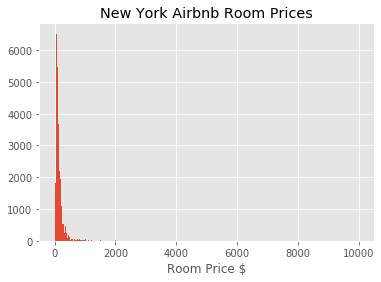

In [11]:
_ = train_df['price'].hist(bins=500)
_ = plt.title('New York Airbnb Room Prices')
_ = plt.xlabel('Room Price $')

print(f'The skewness of the room price is {np.round(train_df["price"].skew(),2)}')

The price distribution of listings is very heavily skewed and it also seems as though there are some rooms listed at zero price. It is worth investigating the two ends of the distribution.

In [12]:
print(f'There are {len(train_df[train_df["price"]==0])} listings with a price of $0\n')
display(train_df[train_df["price"]==0])

There are 11 listings with a price of $0



,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
25795,Contemporary bedroom in brownstone with nice view,86327101,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,1,95,2019-06-21,4.37,6,232,0
25753,"Sunny, Quiet Room in Greenpoint",1641537,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,2,12,2017-10-27,0.53,2,0,0
25634,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Brooklyn,Bushwick,40.69467,-73.92433,Private room,2,16,2019-05-18,0.71,5,0,0
26866,Best Coliving space ever! Shared room.,101970559,Brooklyn,Bushwick,40.69166,-73.90928,Shared room,30,5,2019-05-24,0.26,6,139,0
25796,Cozy yet spacious private brownstone bedroom,86327101,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,1,95,2019-06-23,4.35,6,222,0
23161,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,4,1,2018-01-06,0.05,4,28,0
25794,Spacious comfortable master bedroom with nice view,86327101,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,1,93,2019-06-15,4.28,6,176,0
25778,Modern apartment in the heart of Williamsburg,10132166,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,5,3,2018-01-02,0.15,1,73,0
26841,Coliving in Brooklyn! Modern design / Shared room,101970559,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,30,2,2019-06-22,0.11,6,333,0
25433,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Bronx,East Morrisania,40.83296,-73.88668,Private room,2,55,2019-06-24,2.56,4,127,0


A small number of listings do record a price of $0 which seems likely to be an error. Two possible options are to either impute a room price based on the room characteristics or two drop those listings. Given the very small proportion of listings covered I will choose the option to drop them.

In [13]:
# Drop listings with a price of 0
train_df.drop(train_df[train_df['price']==0].index,inplace=True)
X_test.drop(y_test[y_test==0].index,inplace=True)
y_test.drop(y_test[y_test==0].index,inplace=True)

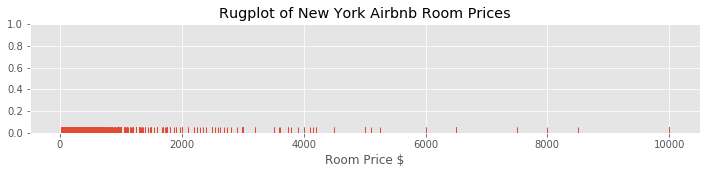

In [14]:
# Create rugplot to see spread of listings
fig = plt.figure(figsize=(12,2))
_ = sns.rugplot(train_df['price'])
_ = plt.title('Rugplot of New York Airbnb Room Prices')
_ = plt.xlabel('Room Price $')

In [15]:
high_prices = train_df.nlargest(10,'price')
display(high_prices)

prices = [500,1000,2000,3000,4000,5000]
for price in prices:
    perc = round(sum((train_df['price']>price)/len(train_df)),4)*100
    print(f'{perc:.2f}% of listings cost more than ${price}')

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
17692,Luxury 1 bedroom apt. -stunning Manhattan views,5143901,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,5,5,2017-07-27,0.16,1,0,10000
9151,Furnished room in Astoria apartment,20582832,Queens,Astoria,40.76810,-73.91651,Private room,100,2,2016-02-13,0.04,1,0,10000
29238,1-BR Lincoln Center,72390391,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,30,0,NaT,0.00,1,83,10000
12342,"Quiet, Clean, Lit @ LES & Chinatown",3906464,Manhattan,Lower East Side,40.71355,-73.98507,Private room,99,6,2016-01-01,0.14,1,83,9999
40433,2br - The Heart of NYC: Manhattans Lower East Side,4382127,Manhattan,Lower East Side,40.71980,-73.98566,Entire home/apt,30,0,NaT,0.00,1,365,9999
30268,Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho,18128455,Manhattan,Tribeca,40.72197,-74.00633,Entire home/apt,30,2,2018-09-18,0.18,1,251,8500
4377,Film Location,1177497,Brooklyn,Clinton Hill,40.69137,-73.96723,Entire home/apt,1,1,2016-09-15,0.03,11,365,8000
42523,70' Luxury MotorYacht on the Hudson,7407743,Manhattan,Battery Park City,40.71162,-74.01693,Entire home/apt,1,0,NaT,0.00,1,364,7500
45666,Gem of east Flatbush,262534951,Brooklyn,East Flatbush,40.65724,-73.92450,Private room,1,8,2019-07-07,6.15,2,179,7500
48043,Luxury TriBeCa Apartment at an amazing price,271248669,Manhattan,Tribeca,40.71206,-74.00999,Entire home/apt,180,0,NaT,0.00,1,365,6500


2.16% of listings cost more than $500
0.50% of listings cost more than $1000
0.17% of listings cost more than $2000
0.09% of listings cost more than $3000
0.06% of listings cost more than $4000
0.04% of listings cost more than $5000


The dataset contains a small proportion of very high priced rooms. Having done some research two reasons are suggested for this:

1. Airbnb have recently started a premium/ luxury service aimed at wealthy people. It seems likely that some of these listings feature in the dataset.

2. There is some suggestion that for listings where the minimum nights are 30 or 31  then the price given is for a month. I cannot find a conclusive verdict on this so will treat all prices as being nightly.

Given the above while the presence of high end properties is an interesting feature of the data it seems reasonable ot conclude that that actually belong to a distinct customer segment, so from a modelling perspectvie should be treated differently. I will therefore split out all listings over $1000, which represents 0.5\% of the data. I will analyse this a bit more but drop it from the main dataset for modelling purposes.

#### High Price Properties

In [16]:
# Split out properties over $1000
high_price_lists = train_df.drop(train_df[train_df['price']<1000].index)

# Remove high price properties from other datasets
train_df.drop(train_df[train_df['price']>=1000].index,inplace=True)
X_test.drop(y_test[y_test>=1000].index,inplace=True)
y_test.drop(y_test[y_test>=1000].index,inplace=True)

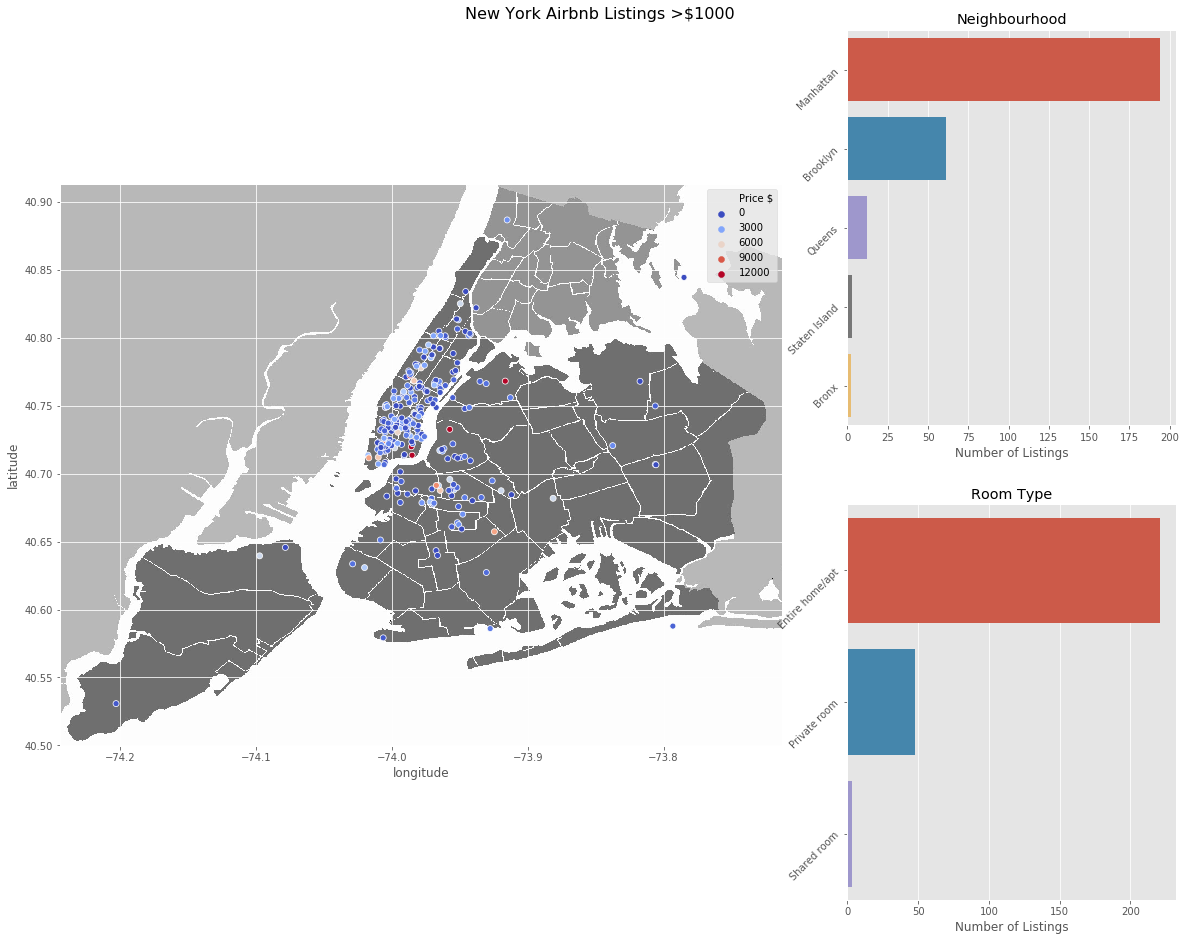

In [17]:
# Graphical analysis of listing prices >$1000
pic = plt.imread('New-York-City.png',0)
fig = plt.figure(figsize=(20,16))
fig.suptitle('New York Airbnb Listings >$1000',fontsize=16,y=0.9)
ax1 = plt.subplot2grid((2,3),(0,0),rowspan=2,colspan=2)
_ = plt.imshow(pic,extent = [min(data['longitude']),max(data['longitude'])\
                             ,min(data['latitude']),max(data['latitude'])])

# Add subplot for scatterplot with same axis extents as underlying image
_ = ax1.axis([min(data['longitude']),max(data['longitude']),min(data['latitude']),max(data['latitude'])])
_ = sns.scatterplot(x='longitude',y='latitude',data=high_price_lists,hue='price',palette='coolwarm')
_ = ax1.legend().texts[0].set_text('Price $')

ax2 = plt.subplot2grid((2,3),(0,2))
_ = sns.barplot(y=high_price_lists['neighbourhood_group'].value_counts().index,\
                x = high_price_lists['neighbourhood_group'].value_counts(),ax=ax2,orient='h')
_ = ax2.set_title('Neighbourhood')
_ = ax2.set_xlabel('Number of Listings')
_ = ax2.tick_params(axis='y',rotation=45)

ax3 = plt.subplot2grid((2,3),(1,2))
_ = sns.barplot(y = high_price_lists['room_type'].value_counts().index,
               x = high_price_lists['room_type'].value_counts(),ax=ax3,orient='h')
_ = ax3.set_title('Room Type')
_ = ax3.set_xlabel('Number of Listings')
_ = ax3.tick_params(axis='y',rotation=45)

The majority of the highest price listings are whole home/ apartments located in Manhatten.

### host_id and calculated_host_listings_count

There is likely to be a limited amount to be learned from the host_id but from the listings_count featur we know that some hosts have more than one property available on Airbnb so it would be interesting to look at this in more detail.

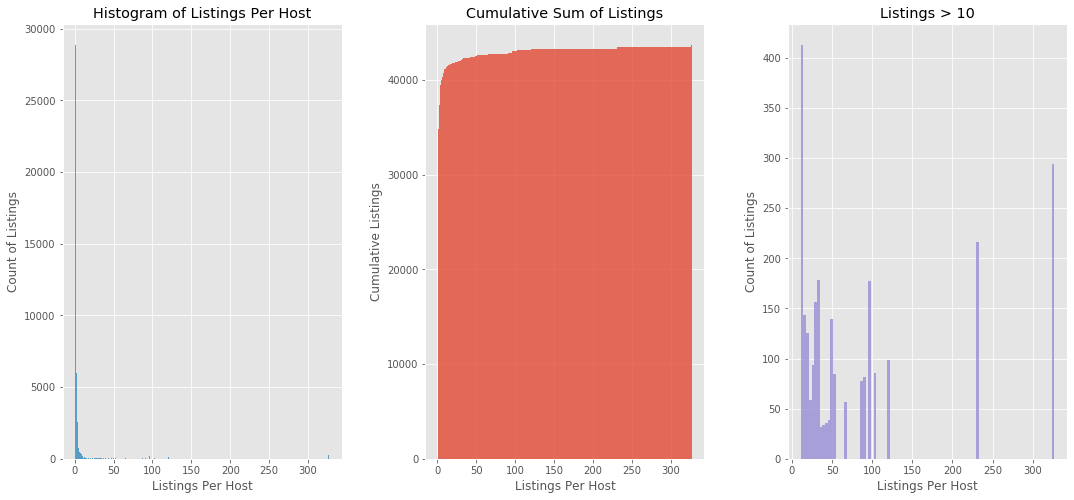

In [18]:
fig,ax = plt.subplots(1,3,figsize=(18,8))
_ = train_df.hist(column = 'calculated_host_listings_count',bins=327,color = colours[1],alpha=0.8,ax=ax[0])
_ = ax[0].set_title('Histogram of Listings Per Host')
_ = ax[0].set_xlabel('Listings Per Host')
_ = ax[0].set_ylabel('Count of Listings')

_ = train_df.hist(column='calculated_host_listings_count',bins = 323,color = colours[0],alpha = 0.8,ax=ax[1],cumulative=True)
_ = ax[1].set_title('Cumulative Sum of Listings')
_ = ax[1].set_xlabel('Listings Per Host')
_ = ax[1].set_ylabel('Cumulative Listings')

_ = train_df[train_df['calculated_host_listings_count']>10].hist(
            column='calculated_host_listings_count',bins = 94,color = colours[2],alpha=0.8,ax=ax[2])
_ = ax[2].set_title('Listings > 10')
_ = ax[2].set_xlabel('Listings Per Host')
_ = ax[2].set_ylabel('Count of Listings')

In [19]:
print(f'The mean number of listings per host is {np.floor(train_df["calculated_host_listings_count"].mean())}')
print(f'The median number of listings per host is {np.floor(train_df["calculated_host_listings_count"].median())}')
print(f'The modal number of listings per host is {np.floor(train_df["calculated_host_listings_count"].mode()[0])}')
print(f'''\nThe modal number of listings accounts for \
{round(len(train_df[train_df['calculated_host_listings_count']==1])/len(train_df),2)*100}% of all listings''')

The mean number of listings per host is 7.0
The median number of listings per host is 1.0
The modal number of listings per host is 1.0

The modal number of listings accounts for 66.0% of all listings


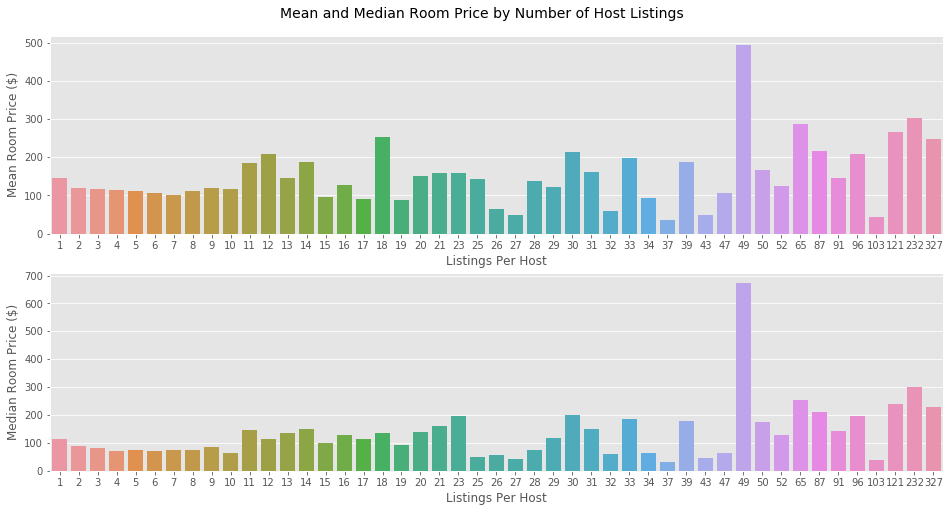

In [20]:
# Look at the average price by the number of listings per host
price_by_number_of_listings = train_df.groupby('calculated_host_listings_count').agg({'price':['mean','median']})
price_by_number_of_listings.rename_axis('Listings Per Host',inplace=True)
price_by_number_of_listings.rename(columns={'mean':'Mean Price','median':'Median Price'},inplace=True)
price_by_number_of_listings.columns = price_by_number_of_listings.columns.droplevel() # Drop top level column index "price"


fig, ax = plt.subplots(2,1,figsize=(16,8))
_ = plt.suptitle('Mean and Median Room Price by Number of Host Listings',fontsize='14',y=0.93)
_ = sns.barplot(x=price_by_number_of_listings.index,y=price_by_number_of_listings['Mean Price'],ax=ax[0])
_ = ax[0].set_ylabel('Mean Room Price ($)')
_ = sns.barplot(x=price_by_number_of_listings.index, y=price_by_number_of_listings['Median Price'],ax=ax[1])
_ = ax[1].set_ylabel('Median Room Price ($)')

There are three groupings with unusually large mean prices for listings of 11, 12 and 49 listings per host. For hosts with 11 and 12 listing the median price is much more in line with surrounding groupings impliying that there may be a small number of high price rooms in those groups. Box plots will help shed some more light on this.

There are 9 different hosts with 11 listings each
There are 14 different hosts with 12 listings each
There are 2 different hosts with 49 listings each


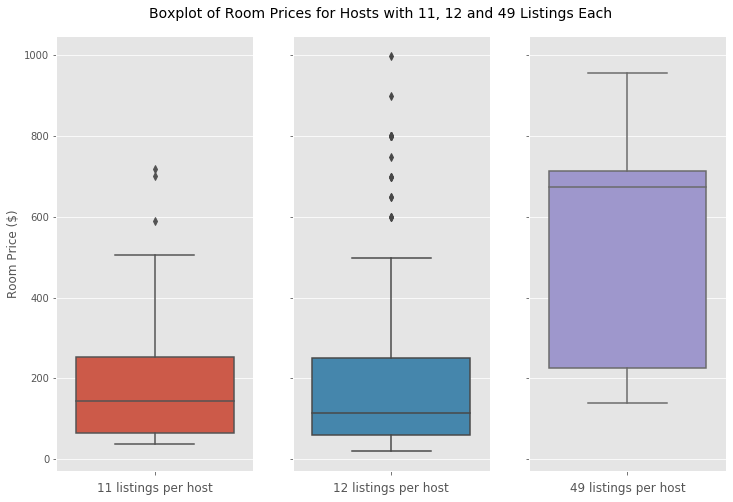

In [21]:
listing_numbers = [11,12,49]
fig, ax = plt.subplots(1,3,figsize=(12,8),sharex=True,sharey=True)
_ = plt.suptitle('Boxplot of Room Prices for Hosts with 11, 12 and 49 Listings Each',y=0.93,fontsize='14')
for ind,listing in enumerate(listing_numbers):
    print(f'''There are {len(train_df[train_df["calculated_host_listings_count"]==listing].groupby("host_id"))}\
 different hosts with {listing} listings each''')
    _ = sns.boxplot(train_df[train_df["calculated_host_listings_count"]==listing]['price'],labels=[''],ax=ax[ind],orient='v',\
                   color=sns_colours[ind])
    _ = ax[ind].set_xlabel(f'{listing} listings per host')
    _ = ax[ind].set_ylabel("")
_ = ax[0].set_ylabel('Room Price ($)')

The dataset is dominated by hosts with a small number of properties, particularly single property hosts, though there are a handful of hosts with over 50 listings. As expected from the mean vs median bar charts, the box plots above show that there are some outlying room prices. The price feature will be examined in more detail later.

### Neighbourhood and Neighbourhood Group

In [22]:
print(f'There are {len(set(train_df["neighbourhood"]))} unique neighbourhoods in the data set')
print(f'There are {len(set(train_df["neighbourhood_group"]))} unique neighbourhood groups in the data set')

There are 221 unique neighbourhoods in the data set
There are 5 unique neighbourhood groups in the data set


With such a high number of neighbourhoods it will be impractical to visualize them all at once on most plots so they will need to be partitioned. First though I will plot a cumulative distribution of the number of listings across neighbourhoods to see how even the distribution is.

In [23]:
# Create dataframe of number of listings per neighbourhood

neighbourhoods = train_df.groupby('neighbourhood').agg({'neighbourhood':'count'})
neighbourhoods.rename(columns={'neighbourhood':'Count'},inplace=True)
neighbourhoods = neighbourhoods.sort_values(by='Count',ascending=False)

The mean number of listings per neighbourhood is 197.0
The median number of listings per neighbourhood is 30.0



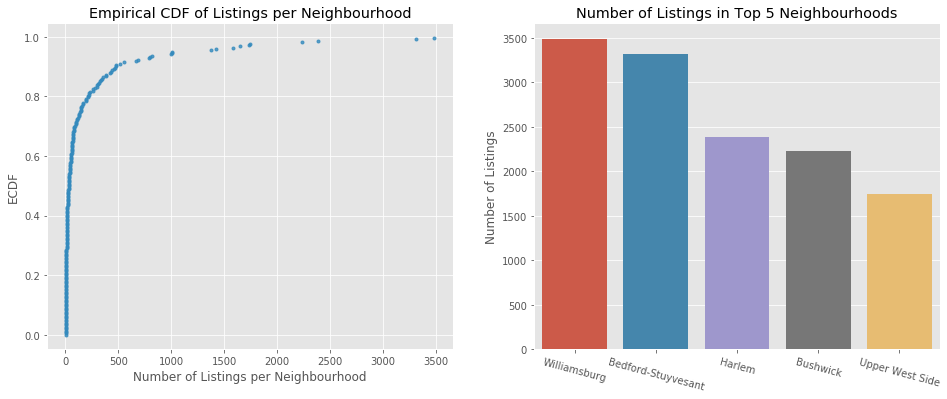

In [24]:
# Plot cumulative distribution of listings across neighbourhoods and number of listings in top 5 neighbourhoods
fig,ax = plt.subplots(1,2,figsize=(16,6))

y = np.arange(len(neighbourhoods['Count']))/len(neighbourhoods['Count'])
x = np.sort(neighbourhoods['Count'])
_ = ax[0].plot(x,y,marker='.',color = sns_colours[1],linestyle='none',alpha = 0.8)
_ = ax[0].set_title("Empirical CDF of Listings per Neighbourhood")
_ = ax[0].set_xlabel("Number of Listings per Neighbourhood")
_ = ax[0].set_ylabel("ECDF")

_ = sns.barplot(x = neighbourhoods.index[:5],y = neighbourhoods['Count'][:5],ax=ax[1]).set_title('Number of Listings in Top 5 Neighbourhoods')
_ = ax[1].set_ylabel('Number of Listings')
_ = ax[1].set_xlabel('')
_ = ax[1].tick_params(axis='x',labelrotation=-15)

print(f'The mean number of listings per neighbourhood is {np.floor(neighbourhoods["Count"].mean())}')
print(f'The median number of listings per neighbourhood is {neighbourhoods["Count"].median()}\n')

The listings are dominated by neighbourhoods with relatively small numbers of listings but there is a long tail with a handful of neighbourhoods having in excess of 1000 lisings.

Moving on to neighbourhood groups, as a non New Yorker it would be useful to get a feel for the geography of the neighbourhoods.

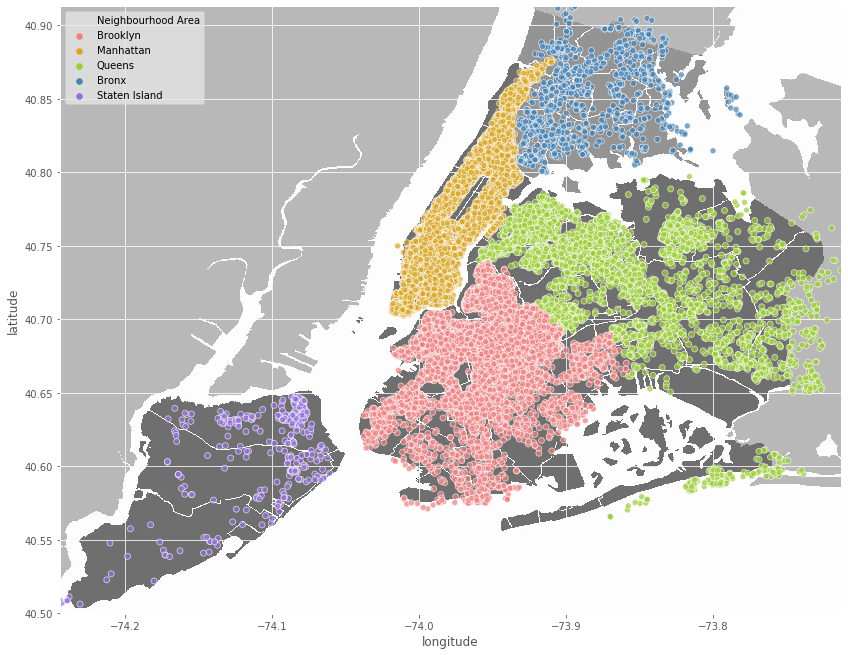

In [25]:
# Create underlying image using map of new york
pic = plt.imread('New-York-City.png',0)
fig,ax = plt.subplots(1,figsize=(14,14))

# Set extends to correspond to coordinate system
_ = plt.imshow(pic,extent = [min(data['longitude']),max(data['longitude']),min(data['latitude']),max(data['latitude'])])

# Add subplot for scatterplot with same axis extents as underlying image
_ = ax.axis([min(data['longitude']),max(data['longitude']),min(data['latitude']),max(data['latitude'])])

# Create colourmap that doesn't have grey in it
colrs = ['lightcoral','goldenrod','yellowgreen','steelblue','mediumpurple']

_ = sns.scatterplot(x = 'longitude',y = 'latitude',hue = 'neighbourhood_group',data = train_df,\
                   alpha = 0.7, palette = colrs)
_ = ax.legend().texts[0].set_text('Neighbourhood Area')

The plot above gives a good sense of the different neighbourhood groups and the deliniation between listings seems consistent. The southern grouping of Queens listings is distinct so it is possible that coding this into a separate group might benefit modelling.

Next I will look at the breakdown of rooms across the neighbourhoods in a bit more detail. On some plots I will miss off the highest price rooms as the distribution has a long tail which will compromise some visualizations.

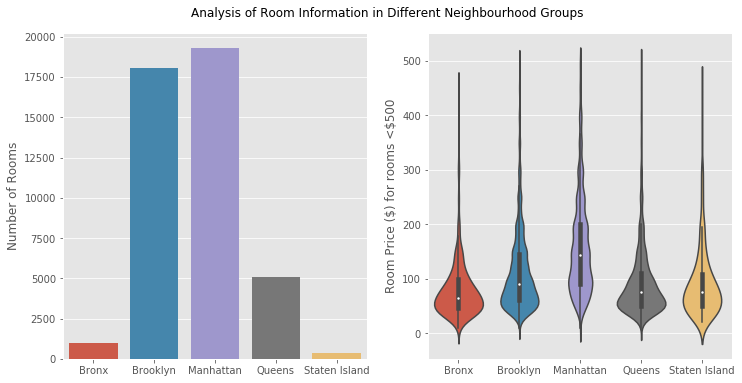

In [26]:
# Create dataframe of rooms in each neighbourhood group
rooms_in_ngroup = train_df.groupby('neighbourhood_group').agg({'name':'count'})

# Create data frame without highest price rooms for plotting
price_less_500 = train_df[train_df['price']<500].sort_values(by='neighbourhood_group')

fig, ax = plt.subplots(1,2,figsize=(12,6))
_ = sns.barplot(x=rooms_in_ngroup.index,y=rooms_in_ngroup['name'],ax=ax[0],orient='v')
_ = plt.suptitle('Analysis of Room Information in Different Neighbourhood Groups',y=0.94)
_ = ax[0].set_xlabel("")
_ = ax[0].set_ylabel('Number of Rooms')

_ = sns.violinplot(x = 'neighbourhood_group',y='price',data = price_less_500,ax=ax[1])
_ = ax[1].set_xlabel("")
_ = ax[1].set_ylabel('Room Price (\$) for rooms <$500')


Brooklyn and Manhattan dominate the rooms listings and are also the groups with the highest median prices. These two features should show up well when plotting using the longitude and latitude coordinates in the next section.

The prices in Manhattan have a narrower and longer distrubuation compoared to the other groups.

### Longitude and Latitude
These features will be most useful for visualizing the locations of individual listings. The ranges of room prices that I want to vizualise are too skewed for using a colour map so I will first create log features of these.

In [27]:
log_data = train_df[['host_id','longitude','latitude']]
log_data['Log Price'] = np.log(train_df['price'])#+abs(min(np.log(train_df['price'])))
log_data['Log Reviews per Month'] = np.sqrt(train_df['reviews_per_month'])

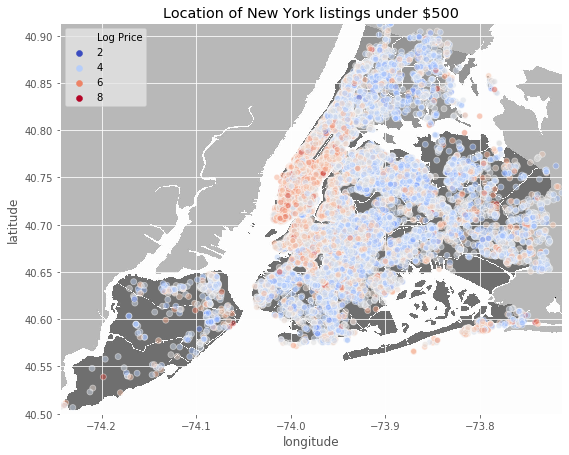

In [28]:
# Plot listing locations with room price as a colourmap
fig, ax = plt.subplots(1,1,figsize=(9,9))
# Set extends to correspond to coordinate system
_ = plt.imshow(pic,extent = [min(data['longitude']),max(data['longitude']),\
                             min(data['latitude']),max(data['latitude'])])

# Add subplot for polygons with same axis extents as underlying image
_ = ax.axis([min(data['longitude']),max(data['longitude']),min(data['latitude']),\
             max(data['latitude'])])

_ = sns.scatterplot(x='longitude',y='latitude',data=log_data,hue='Log Price',\
                    palette = 'coolwarm',alpha=0.5).set_title('Location of New York listings under $500')

### Room Type

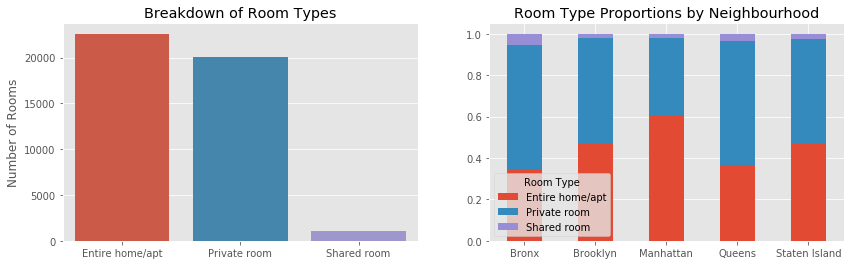

In [29]:
# Plot breakdown of room types and how they vary per neighbourhood
room_types_by_neighbourhood = pd.crosstab(train_df['neighbourhood_group'],train_df['room_type'],\
                                          normalize='index')

fig, ax = plt.subplots(1,2,figsize=(14,4))

_ = room_types_by_neighbourhood.plot.bar(stacked=True,ax=ax[1])
_ = ax[1].legend(title='Room Type').texts[0]
_ = ax[1].set_title('Room Type Proportions by Neighbourhood')
_ = ax[1].set_xlabel("")
_ = ax[1].tick_params(axis='x',rotation=360)

_ = sns.barplot(x=train_df['room_type'].value_counts().index,y = train_df['room_type'].value_counts(),ax=ax[0])
_ = ax[0].set_title('Breakdown of Room Types')
_ = ax[0].set_ylabel("Number of Rooms")

In [30]:
# Check median price of each room type
room_types = train_df['room_type'].unique()
for room in room_types:
    med_price = round(np.median(train_df['price'][train_df['room_type']==room]),0)
    print(f'The median price of a {room} is ${med_price}')

The median price of a Entire home/apt is $160.0
The median price of a Private room is $70.0
The median price of a Shared room is $45.0


Shared rooms are by far the smallest proportion in the data set and also have the lowest median price. Private rooms and entire homes/ apartments are fairly evenly split but entire homes/ apartments have a much higher median price. Manhattan has the highest proportion of entire homes of the five neighbourhood groups which helps to explain why it has the highest median listing prices as discovered earlier in the analysis.

### Minimum Nights

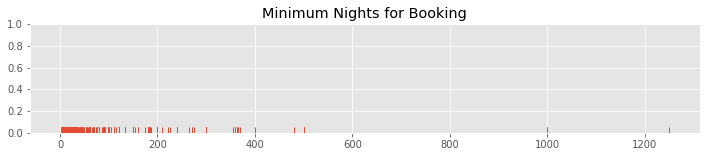

In [31]:
# Look at spread of minimum nights
fig = plt.figure(figsize=(12,2))
_ = sns.rugplot(train_df['minimum_nights']).set_title('Minimum Nights for Booking')

There are a small number of listings with a very high minimum number of nights. I will look more closely at those listings with a minimum requirement of longer than one year.

In [32]:
train_df[train_df['minimum_nights']>365]

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
13404,Historic Designer 2 Bed. Apartment,2697686,Manhattan,Harlem,40.82915,-73.94034,Entire home/apt,999,2,2018-01-04,0.07,1,42,99
2854,Information Missing,6676776,Manhattan,Battery Park City,40.71239,-74.01620,Entire home/apt,1000,0,NaT,0.00,1,362,400
10829,Brand New Luxury Apt Lease Takeover,43945071,Queens,Long Island City,40.74654,-73.95778,Entire home/apt,480,0,NaT,0.00,1,365,199
7355,Beautiful Fully Furnished 1 bed/bth,3680008,Queens,Long Island City,40.75104,-73.93863,Entire home/apt,500,30,2018-06-24,0.57,1,90,134
5767,Prime W. Village location 1 bdrm,17550546,Manhattan,Greenwich Village,40.73293,-73.99782,Entire home/apt,1250,2,2014-11-09,0.03,1,365,180
1305,800sqft apartment with huge terrace,2798644,Brooklyn,Bushwick,40.70202,-73.92402,Entire home/apt,370,6,2018-04-15,0.09,1,365,115
14285,Peaceful apartment close to F/G,2228137,Brooklyn,Kensington,40.64779,-73.97956,Private room,500,0,NaT,0.00,1,358,45
15946,"Bright Luxury Studio, Central Loc.",16476167,Manhattan,Midtown,40.74513,-73.98475,Entire home/apt,366,0,NaT,0.00,1,365,250
11193,Zen Room in Crown Heights Brooklyn,8996336,Brooklyn,Crown Heights,40.67255,-73.94914,Private room,500,10,2016-09-22,0.22,1,365,50
38664,Shared Studio (females only),200401254,Manhattan,Greenwich Village,40.73094,-73.99900,Shared room,999,0,NaT,0.00,1,365,110


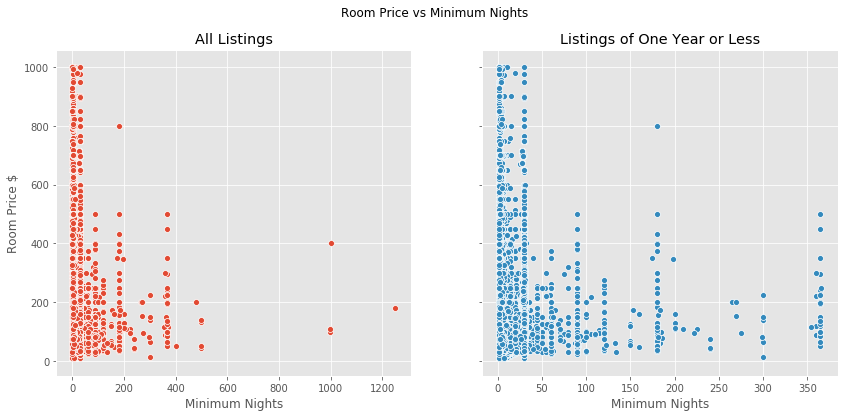

In [33]:
# Look at scatter of prices against minimum nights
fig, ax = plt.subplots(1,2,figsize=(14,6),sharey=True)
plt.suptitle('Room Price vs Minimum Nights')

# Set up dataframe excluding bookings longer than one year
train_df2 = train_df[train_df['minimum_nights']<367]

# Add plot axes
_ = sns.scatterplot(x='minimum_nights',y='price',data=train_df,ax=ax[0]).set_title('All Listings')
_ = ax[0].set_ylabel('Room Price $')
_ = ax[0].set_xlabel('Minimum Nights')

_ = _ = sns.scatterplot(x='minimum_nights',y='price',data=train_df2,ax=ax[1],\
                       color = sns_colours[1]).set_title('Listings of One Year or Less')
_ = ax[1].set_xlabel('Minimum Nights')

The listings of over a year still seem odd on closer inspection and do not seem to fit a pattern. These will be excluded from the learning algorithm.

Looking at the listings with a mimimum requirement of less than a years stay the majority of these require less than a week mimimum stay. There are clusters at intervals which make sense in terms of our calendar, e.g. one month, 3 months, 6 months and 1 year.

The highest prices listings are all short duration but there is not a clear linear relationship between price and minimum night requirements beyond this.

### Number of Reviews, Reviews per Month and Last Review

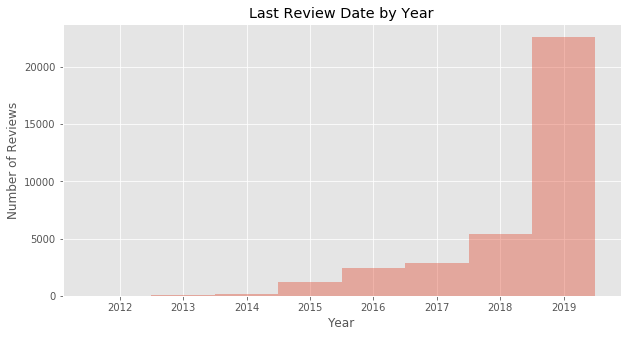

In [34]:
# Look at last review date by year
train_df['review_year'] = train_df['last_review'].dt.year

fig = plt.figure(figsize=(10,5))
_ = sns.distplot(train_df['review_year'],kde=False,bins=[2011.5,2012.5,2013.5,2014.5\
                                                         ,2015.5,2016.5,2017.5,2018.5,2019.5])\
.set_title('Last Review Date by Year')
_ = plt.xlabel('Year')
_ = plt.ylabel('Number of Reviews')

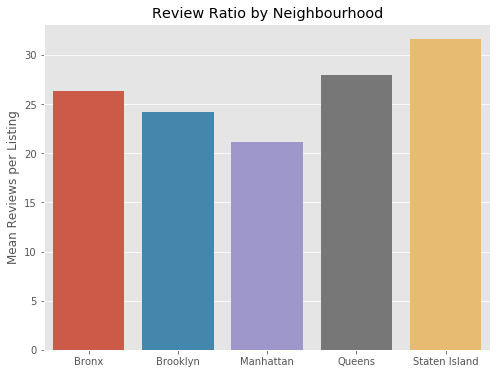

In [35]:
# Look at number of reviews in each neighbourhood group
reviews_in_neighbourhood = train_df.groupby('neighbourhood_group')\
.agg({'name':'count','number_of_reviews':'sum'})
reviews_in_neighbourhood['ratio'] = reviews_in_neighbourhood['number_of_reviews']/reviews_in_neighbourhood['name']
plt.figure(figsize=(8,6))
_ = sns.barplot(x = reviews_in_neighbourhood.index,y = reviews_in_neighbourhood['ratio'],orient='v')
_ = plt.title('Review Ratio by Neighbourhood')
_ = plt.xlabel("")
_ = plt.ylabel('Mean Reviews per Listing')
_ = plt.tick_params(axis='x',rotation = 360)

As would be expected by the clear modal year for last review is 2019, the year of the dataset. There are though a number of listings without a review in over three years. The presumption is that any listing still on the site is active so to not have been reviewed for so long in curious. It shoulde be noted that there are a number of listings which have never been reviewed. It would have been useful to have records for how often and on what dates listings have been booked as without this information it is not possible to do a full analysis of the review years.

There are differences between the regularity with which different neighbourhood groups receive reviews. This may be linked to room type.

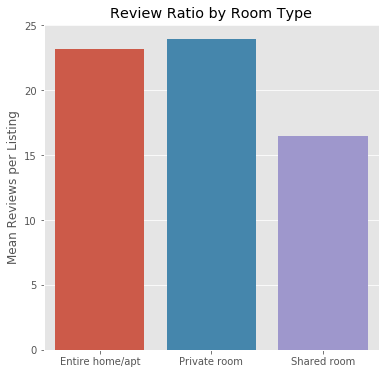

In [36]:
# Look at reviews per room type
room_type_reviews = train_df.groupby('room_type').agg({'name':'count','number_of_reviews':'sum'})
room_type_reviews['ratio'] = room_type_reviews['number_of_reviews']/ room_type_reviews['name']
fig = plt.figure(figsize=(6,6))
_ = sns.barplot(x = room_type_reviews.index,y=room_type_reviews['ratio'],orient='v')
_ = plt.title('Review Ratio by Room Type')
_ = plt.xlabel("")
_ = plt.ylabel("Mean Reviews per Listing")

There are differences in the average review rate across neighbourhoods which is likely to be driven by the different review rates by room type combined with the differences in room type distribution between the neighbourhoods.

A next question to look at is whether there is a difference in price between those listings which have been reviewed and those which haven't.

In [37]:
train_df['has_review'] = train_df['number_of_reviews']>0
print('Mean listing price split by whether the listing has been reviewed \n')
has_review = train_df.groupby('has_review').agg({'price':'mean'})
display(has_review)
print('\nProportion of room types split by whether a listing has been reviewed \n')
display(pd.crosstab(train_df['has_review'],train_df['room_type'],normalize='index'))

Mean listing price split by whether the listing has been reviewed 



,price
has_review,
False,159.618801
True,135.149531



Proportion of room types split by whether a listing has been reviewed 



room_type,Entire home/apt,Private room,Shared room
has_review,,,
False,0.498707,0.468796,0.032497
True,0.521462,0.456688,0.021850


Listings without reviews actually have a lower mean price, even despite listings without reviews containing a higher proportion of the lower priced shared rooms. I will perform a bootstrap test to check wether this difference is significant.

In [38]:
# Set up bootstrap test for mean price difference
difference = has_review.loc[False] - has_review.loc[True]

# Find size of samples to draw
no_reviews_size = sum(train_df['has_review']==False)
reviews_size = sum(train_df['has_review']==True)

# Initialize bootstrap variables
reps = 1000
differences = []

for i in range(reps):
    sample1 = train_df.sample(no_reviews_size,replace=True)
    sample2 = train_df.drop(sample1.index)
    
    sample1_price = np.mean(sample1['price'])
    sample2_price = np.mean(sample2['price'])
    differences.append(sample1_price-sample2_price)

The price difference between listings with and without reviews is $24.5.
The maximum price difference in 1000 boostrap samples was $4.2


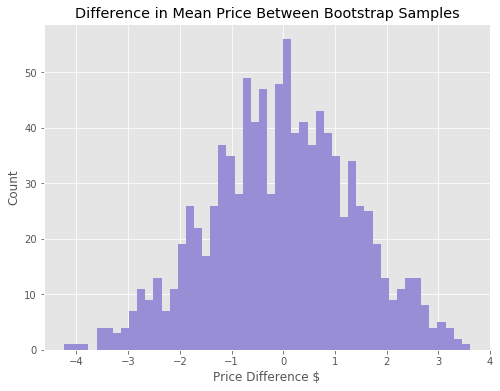

In [39]:
# Review results of bootstrapping
fig = plt.figure(figsize=(8,6))
_ = plt.hist(differences, bins=50,color=colours[2])
_ = plt.title('Difference in Mean Price Between Bootstrap Samples')
_ = plt.xlabel('Price Difference $')
_ = plt.ylabel('Count')

print(f'''The price difference between listings with and without reviews is ${round(difference[0],1)}.
The maximum price difference in {reps} boostrap samples was ${round(max(map(abs,differences)),1)}''')

From bootstrap testing it is clear that the price difference between listings with and without a review is significant so should be factored in to modelling.

I will now look into whether it is possible to tell something about how busy a host has been since registering on the site. I will need to try and account for different lengths of stay as a high number of short stays could result in the same occupancy rate as a smaller number of long stays

41.1% of listings with at least one review average more than one review per month

32.7% of all listings average more than one review per month



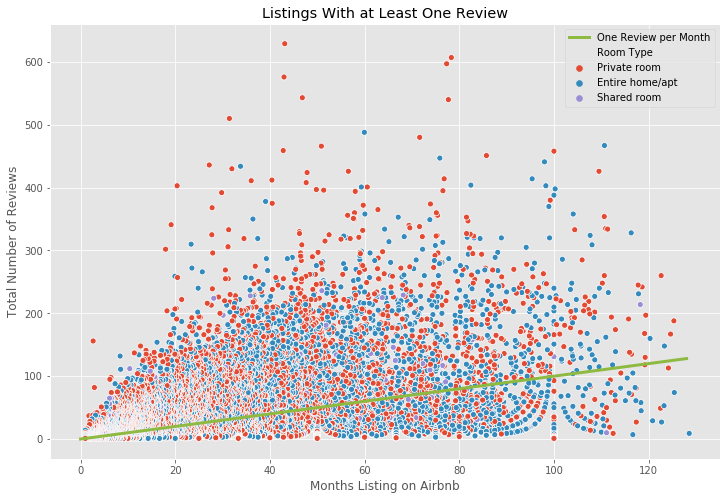

In [40]:
# Extract time on site from total reviews and reviews per month - this will not work for listings with no reviews
train_df['months_on_site'] = train_df['number_of_reviews']/train_df['reviews_per_month']
train_df['months_on_site'].fillna(0,inplace=True)
fig = plt.subplots(figsize=(12,8))
x = train_df[train_df['months_on_site']>0]['months_on_site']
scatter = sns.scatterplot(x=x,y='number_of_reviews',data=train_df,hue='room_type',)

x2 = np.arange(0,max(train_df['months_on_site']))
y = x2

line, = plt.plot(x2,y,color=colours[5],linewidth=3,label='One Review per Month')

_ = plt.title('Listings With at Least One Review')
_ = plt.xlabel('Months Listing on Airbnb')
_ = plt.ylabel('Total Number of Reviews')
_ = plt.legend().texts[1].set_text('Room Type')

perc = sum(train_df['reviews_per_month']>1)
at_least_1 = sum(train_df['number_of_reviews']>0)
print(f'{perc/at_least_1*100:.1f}% of listings with at least one review average more than one review per month\n')
print(f'{perc/train_df.shape[0]*100:.1f}% of all listings average more than one review per month\n')

Most listings average fewer than one review per month. Airbnb estimate that around 70% of guests leave reviews so even adjusting for this it seems that most listings are rented out less than once per month. This would also suggest that 70% of listings without any reviews have never been rented out.

There are a number of site which are clearly averaging significantly above one review per month even without adjusting the figures.

It should be noted that one factor not considered here is the average length of listing.

### Availability

In [41]:
top_availabilities = train_df['availability_365'].value_counts().to_frame().head(10)
top_availabilities.rename({'availability_365':'Count'},axis='columns',inplace=True)
top_availabilities.rename_axis('Availability (days per year)',inplace=True)

display(top_availabilities)

,Count
Availability (days per year),
0,15698
365,1118
364,428
1,364
5,311
89,308
3,279
179,271
90,253


Over a third of the reduced dataset have an availability of 0 set. Reading up on how listing works it seems that this is how owners indicate that their listing is not currently available. There is no way to tell from the available data how long a zero availbility has been set for and therefore whether this listing is long- or short-term inactive.

The next most common availabilities are for full years which are probably hotels using the Airbnb website as another way to sell rooms. After that are a collection of short term availabilites and entries around three and six months in duration.

In [42]:
# Look at how mean availability varies with room type
room_avail = train_df.groupby('room_type').agg({'availability_365':'mean'})
display(room_avail)

,availability_365
room_type,
Entire home/apt,111.229013
Private room,110.754022
Shared room,161.866667


As with other analytics shared rooms are an outlier. It seems like there is a clear difference in the market for people listing a room in a shared residence compared to those listing an entire residence or a private room. While the latter two are similar on most measures the higher price of whole homes/ apartments would make sense as they are liekly to have a larger footprint.

### EDA Conclusions
Following the exploration of the data above a number of observations can be drawn:
- The price distribution is highly right skewed. Even when the 0.5% of listings with prices over $1000 are removed there is still a heavy skew to the data. The majority of the highest priced listings are in Manhattan.
- Around 66\% of hosts only have a single listing on the site but a small number have in excess of 50 listings and the highest single host has 327 listings. Some of the hosts with higher numbers of listings seem to be hotls.
- How listings are spread across the 200+ neighbourhoods of New York is very uneven. The median number of listings per neighbourhood is 30 but the mean in 197. This is skewed by a handful of neighbourhood which have over 1000 listings. Moving up a level to look at Neighbourhood Groups Manhattan and Brooklyn have more listings by a factor of 4+ than the other three groups. The price distribution of listings in these groups is also distinct, tending - towards higher prices.
- The majority of listings are for whole ccomodations of private rooms. The mean price varies considerably by listing type and the variation of price across neighbourhoods looks to be in large part driven by the different room mixes.
- Most listings on Airbnb are likely rented out fewer than once per month. There are some very popular listings but also a significant proportion which have likely never been rented.
- There are high occurrence modalities in the minimum night requirements and annual availability which correspond to typical calendar intervals, e.g. 7 nights, 30 nights, then 90, 180 and 365 nights. There are also a significant number of listings showing a zero availability but it is not possible to tell how long this has been the case.
- Shared rooms are the least likely to be reviewed but it seems that not having a review is correlated with a higher room price.

## Predicting Prices
Having examined the available data to understand it I will now attempt to build a model to predict the price of listings in the dataset. This is a regression problem so I will use mean squared error at the metric.

I will reimport that data from scratch, apply the cleaning methods developed above and split into training and test sets using a random seed of 27 so that I am not inadvertantly seeing previously hidden data.

I will then perform feature engineering before moving on to test and develop models.

In [43]:
# Reimport Data
data = pd.read_csv('AB_NYC_2019.csv', parse_dates = ['last_review'])
data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [44]:
# Clean and split data using methods identified during EDA
def clean_and_split(df):
    '''Returns cleaned and split data: training, testing'''
    temp = df.copy()
    temp = temp.drop(['id','host_name'],axis=1)
    temp['name'] = temp['name'].fillna('Information Missing')
    temp['reviews_per_month'] = temp['reviews_per_month'].fillna(0)
    temp = temp.drop(temp[temp['price']==0].index)
    temp = temp.drop(temp[temp['price']>1000].index)
    
    X_tr,X_te,y_tr,y_te = train_test_split(temp.drop(['price'],axis=1),temp['price'],\
                                           test_size=0.1,random_state=27)
    
    training = pd.concat([X_tr,y_tr],axis=1)
    testing = pd.concat([X_te,y_te],axis=1)
    
    return training, testing
    

In [45]:
# Apply cleaning function to get training and test data set
train_df,test_df = clean_and_split(data)

We know from previous examination that the target variable, price, is highly skewed. Removing the highest price rooms will have helped but further processing will likely be needed.

In [46]:
print(f'The skewness of the listing price is {train_df["price"].skew():.2f}')
log_price = np.log(train_df['price'])
print(f'\nThe skewness of the logarithm of the price is {log_price.skew():.2f}')

The skewness of the listing price is 2.94

The skewness of the logarithm of the price is 0.31


Taking the log of the price brings it into an acceptable range. Next I will look at the correlation between numerical variables.

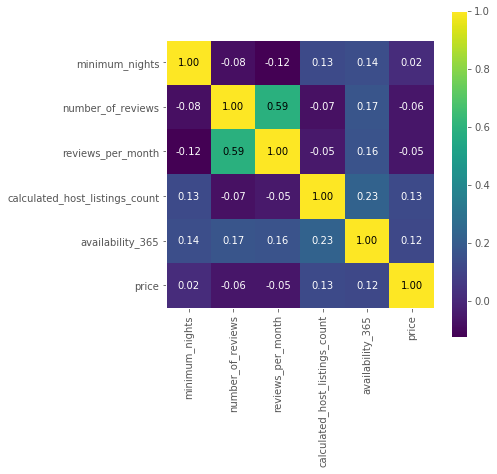

In [47]:
# Select only numeric features
numeric_df = train_df.select_dtypes(include=['int64','float64'])
numeric_df.drop(['host_id','longitude','latitude'],axis=1,inplace=True)

# Create correlation matrix
correlation = numeric_df.corr()

hm = heatmap(correlation.values,column_names=correlation.columns,row_names=correlation.columns,\
            figsize=(6,6),column_name_rotation=90)

There is not a high degree of correlation between any of the numerical variables and the price which is not ideal for a model with good predictive power. The only high degree of cross-correlation is between the number of reviews and the reviews per month, which is unsurprising.

#### calculated_host_listings_count and availability_365

In [48]:
print(f'''The skewness of the host listings count is\
 {train_df["calculated_host_listings_count"].skew():.2f}''')

log_listings = np.log(train_df['calculated_host_listings_count'])
box_listings = boxcox(train_df['calculated_host_listings_count'])

print(f'''The skewness of the log of the host listings count is\
 {skew(log_listings):.2f}''')

print(f'''The skewness of the boxcox transform of the host listings count is\
 {skew(box_listings[0]):.2f} using a lambda of {box_listings[1]:.3f}''')

print(f'\nThe skewness of the availability is {train_df["availability_365"].skew():.2f}')

The skewness of the host listings count is 7.88
The skewness of the log of the host listings count is 2.74
The skewness of the boxcox transform of the host listings count is 0.87 using a lambda of -1.298

The skewness of the availability is 0.77


Taking a boxcox transform of the host listings count brings it to an acceptable level of skewness while the availability does not need transforming to achieve this.

I will now write a function to process the training and test sets into the form I will use for modelling. The steps will be:
- Create a column of log transformer price to use as the target variable
- Binary encode the Room Type and Neighbourhood Group features
- Create a feature for whether or not a listing has been reviewed
- Perform a boxcox transformation with a lambda of -1.298 on the host listings count feature
- Only retain the features I will use for modelling

In [49]:
def create_model_df(df):
    temp = df.copy()
    temp['log_price'] = np.log(temp['price'])
    temp = pd.get_dummies(temp,columns=['room_type','neighbourhood_group'])
    temp['has_review'] = temp['number_of_reviews']>0
    temp['calculated_host_listings_count'] = boxcox(temp['calculated_host_listings_count'],lmbda=-1.298)
    temp = temp.drop(['name','host_id','neighbourhood','latitude','longitude','number_of_reviews',\
                     'last_review','reviews_per_month','price'],axis=1)
    
    return temp

In [50]:
visible_df = create_model_df(train_df)
testing_df = create_model_df(test_df)

visible_df.head()

,minimum_nights,calculated_host_listings_count,availability_365,log_price,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,has_review
25723,30,0.000000,81,5.521461,1,0,0,0,0,1,0,0,True
10482,3,0.000000,0,5.521461,1,0,0,0,0,1,0,0,True
1407,8,0.000000,0,4.595120,1,0,0,0,0,1,0,0,True
21232,2,0.585309,268,5.783825,0,1,0,0,0,1,0,0,False
28933,4,0.457096,102,4.382027,0,1,0,0,0,1,0,0,True


In [51]:
# Split the visible data into training and validation sets
X_train,X_valid,y_train,y_valid = train_test_split(visible_df.drop('log_price',axis=1),\
                                                  visible_df['log_price'],test_size=0.2,random_state=27)

training_df = pd.concat([X_train,y_train],axis=1)
validation_df = pd.concat([X_valid,y_valid],axis=1)

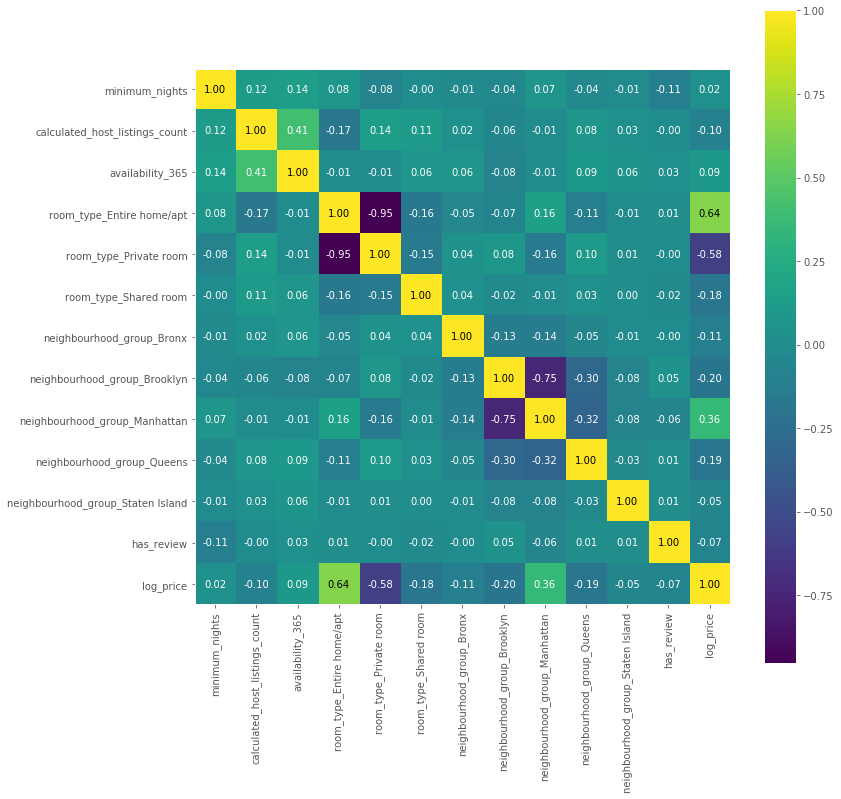

In [52]:
# Create correlation matrix
correlation = training_df.corr()

hm = heatmap(correlation.values,column_names=correlation.columns,row_names=correlation.columns,\
            figsize=(12,12),column_name_rotation=90)

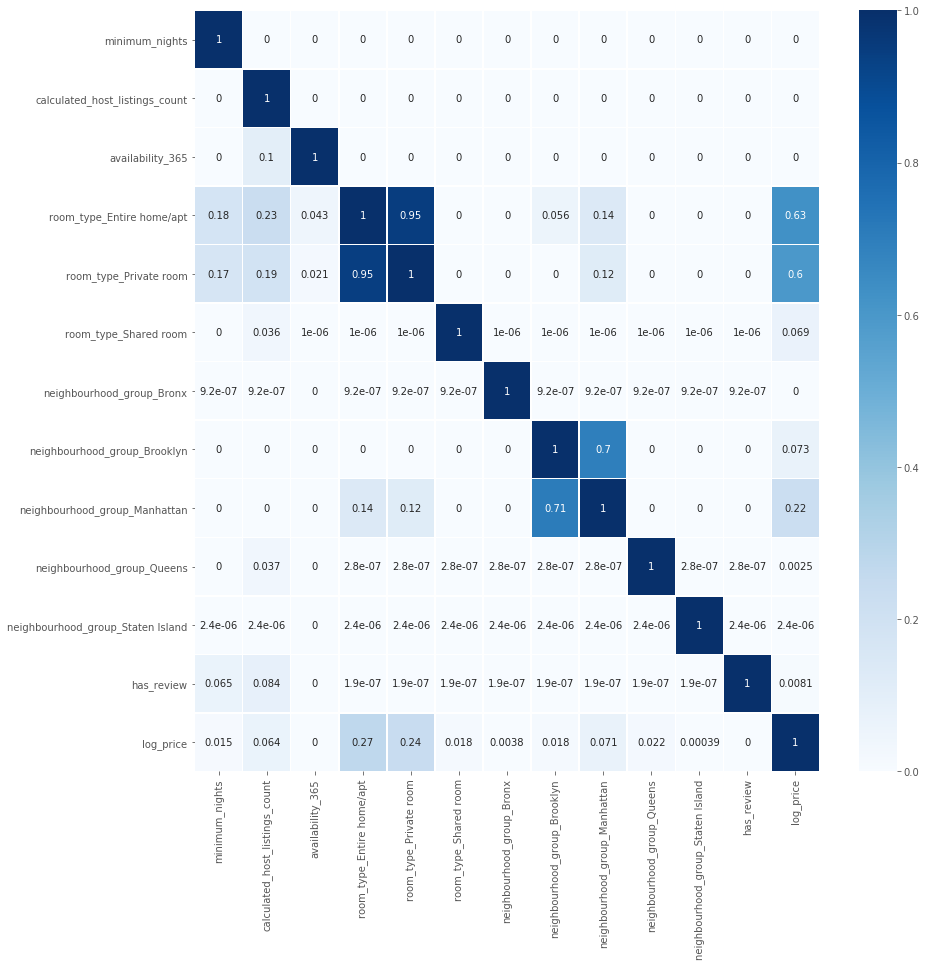

In [53]:
# Implement predictive power matrix to compare with correlation
pps_mat = pps.matrix(training_df)
_ = plt.figure(figsize=(14,14))
_ = sns.heatmap(pps_mat, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

Even with feature engineering there does not look to be a great deal of predictive power in the available information.

I will first construct a naive model to use as a baseline before testing a the most likely model candidates. I will select the most promising subset of these to tune on the validation set before using the test data for the final evaluation.

In [54]:
# Select model features to use as estimators
estimators = training_df.columns.to_list()
estimators.remove('log_price')

In [55]:
# Construct and evaluate naive model
mean_price = training_df['log_price'].mean()
naive_preds = training_df['log_price']-mean_price

# Find rmse and convert from log price to price in $
naive_rmse = (mean_squared_error(np.exp(training_df['log_price']),np.exp(naive_preds))**0.5)
print(f'The RMSE of the naive model is ${naive_rmse:.2f}')

The RMSE of the naive model is $181.88


In [56]:
# Instantiate Base Models
lin_reg = LinearRegression()
svr = SVR()
lasso = Lasso()
xgbr = xgb.XGBRegressor()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

models = [('Linear Regression',lin_reg),('Support Vector',svr),('Lasso',lasso),\
         ('XGBoost',xgbr),('Decision Tree',dt),('Random Forest',rf)]

In [57]:
# Use CV socring with neg mean squared error to assess base models. For speed use only 10000 training examples
scores = defaultdict(list)
for name, model in models:
    cv = cross_val_score(model,X=training_df.loc[:10000,estimators],y = training_df.loc[:10000,'log_price'],\
                        scoring='neg_mean_squared_error',verbose=1,cv=5)
    scores[name] = cv.mean()

display(pd.DataFrame(pd.Series(scores),columns=['MSE']))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[14:26:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.0s finished


,MSE
Linear Regression,-0.222990
Support Vector,-0.308113
Lasso,-0.445214
XGBoost,-0.205057
Decision Tree,-0.302976
Random Forest,-0.230581


The Linear Regression, XGBoost and Random Forest models have the best performance. Random Forest is the costliest to tune and train so for this task I will take forward Linear Regression and XGBoost. The linear regression model does not have any hyperparameters to tune.

In [58]:
# XGBoost
xgbr_params = {'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [3,4,5],
              'silent': [1],
              'subsample': [0.5,0.7,0.8],
              'colsample_bytree': [0.6,0.7,0.8],
              'n_estimators': [100,200]}

xgbr_gs = RandomizedSearchCV(xgbr,param_distributions= xgbr_params,n_iter = 100,scoring='neg_mean_squared_error',\
                             cv=3,verbose=1)
xgbr_gs.fit(validation_df[estimators],validation_df['log_price'])
print(f'The lowest MSE achieved is: {xgbr_gs.best_score_:.3f} with parameters:{xgbr_gs.best_params_}')


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.8min finished


The lowest MSE achieved is: -0.204 with parameters:{'subsample': 0.8, 'silent': 1, 'objective': 'reg:linear', 'n_estimators': 200, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


Having set up three models I will now train them on the full set of training data then evaluate their performance. As a reminder the RMSE of the naive model was $181.

#### Linear Regression

In [59]:
# Obtain RMSE score for model
lin_reg.fit(training_df[estimators],training_df['log_price'])
lin_reg_preds = lin_reg.predict(testing_df[estimators])
lin_reg_rmse = (mean_squared_error(np.exp(testing_df['log_price']),np.exp(lin_reg_preds))**0.5)

print(f'The RMSE of the Linear Regression model is ${lin_reg_rmse:.3f}')

The RMSE of the Linear Regression model is $96.736


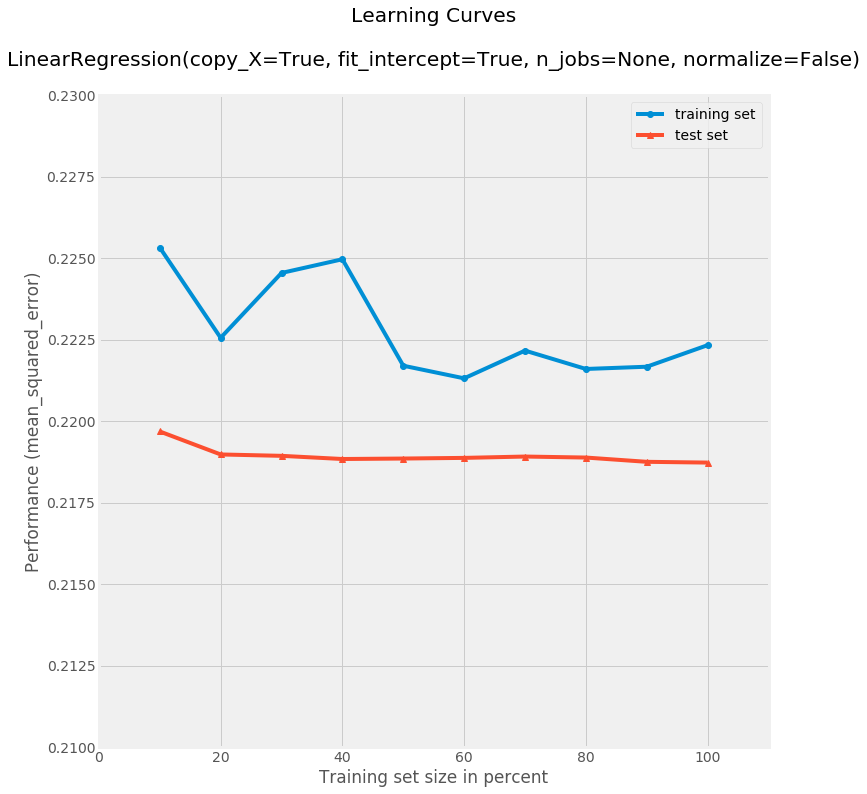

In [60]:
# Plot learning curves
fig = plt.figure(figsize=(12,12))
_ = plot_learning_curves(training_df[estimators], training_df['log_price'], testing_df[estimators],\
                     testing_df['log_price'], lin_reg,scoring='mean_squared_error')
_ = plt.ylim(0.21,0.23)

In [61]:
xgbr_final = xgb.XGBRegressor(**xgbr_gs.best_params_)
xgbr_final.fit(training_df[estimators],training_df['log_price'])
xgbr_preds = xgbr_final.predict(testing_df[estimators])
xgbr_rmse = (mean_squared_error(np.exp(testing_df['log_price']),np.exp(xgbr_preds))**0.5)

print(f'The RMSE of the XGBoost model is ${xgbr_rmse:.3f}')

The RMSE of the XGBoost model is $92.561


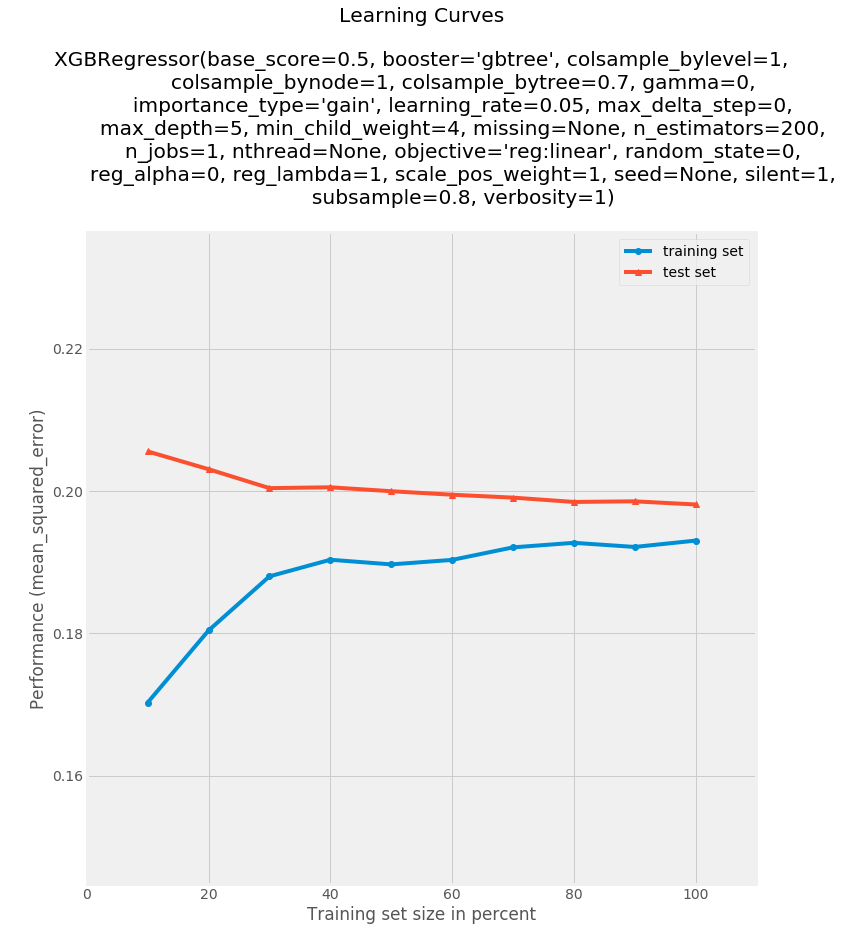

In [62]:
# Plot learning curves
fig = plt.figure(figsize=(12,12))
_ = plot_learning_curves(training_df[estimators], training_df['log_price'], testing_df[estimators],\
                     testing_df['log_price'], xgbr_final,scoring='mean_squared_error')

XGBoost performs the best but a RMSE of $92 is very high given the typical room price in the data set. I will analyse the errors of the XGB model to see if there is any pattern.

In [63]:
# Add columns for actual price, predicted price and absolute error to dataframe.
testing_df['price'] = np.exp(testing_df['log_price'])
testing_df['predicted_price'] = np.exp(xgbr_preds)
testing_df['error'] = abs(testing_df['price']-testing_df['predicted_price'])

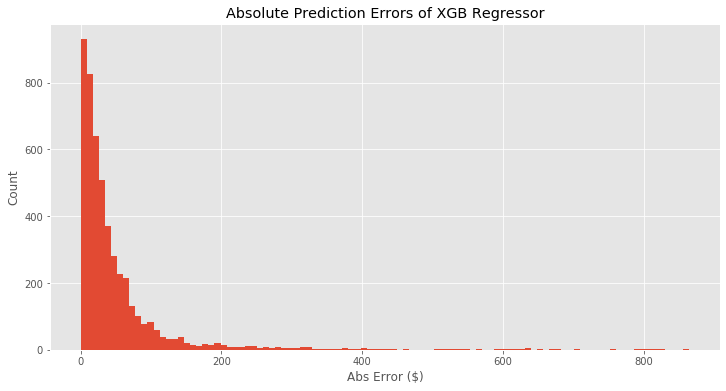

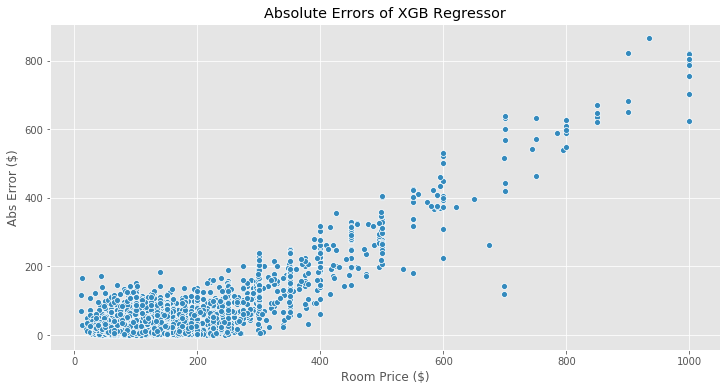

In [64]:
# Look at scatterplot and histogram of errors.
fig,ax = plt.subplots(1,figsize=(12,6))
_ = testing_df.hist('error',bins=100,ax=ax)
_ = ax.set_title('Absolute Prediction Errors of XGB Regressor')
_ = ax.set_xlabel('Abs Error ($)')
_ = ax.set_ylabel('Count')

fig,ax1 = plt.subplots(1,figsize=(12,6))
_ = sns.scatterplot(x='price',y='error',data=testing_df,ax=ax1,color=sns_colours[1])
_ = ax1.set_title('Absolute Errors of XGB Regressor')
_ = ax1.set_xlabel('Room Price ($)')
_ = ax1.set_ylabel('Abs Error ($)')

Above a room price of ~$250 the absolute prediction error begins to increase linearly with room price. This is another indication that the model does not have sufficient predictive power to account for the variation in the dataset. Givent the relatively close values of the training and test error and how little they change with the size of the training set the logical conclusion is that the available features are not sufficient to construct a good model.